## Loading Packages, Data, and Conducting EDA

In [2]:
!pip install phrasemachine
!pip install rake_nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 73.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for phrasemachine: filename=phrasemachine-1.0.7-py3-none-any.whl size=2694854 sha256=ef5de02169e9b220ac6fa6bf428914124dca0a70ce617296e7ded599e0c2d864
  Stored in directory: /root/.cache/pip/wheels/84/b3/4d/e849568396756266ef3ae974fc5ab86965f706deffd8e74973
Successfully built phrasemachine


In [3]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams, FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import pandas as pd
import os
import numpy as np
import phrasemachine
from rake_nltk import Rake
import re
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array
from numpy import argmax
import gensim

In [3]:
# Set up notebook to display multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [38]:
#downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [5]:
stop_words = set(stopwords.words("english"))

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
data = pd.read_csv('/content/drive/MyDrive/2016_US_election_tweets_100k.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   100000 non-null  int64  
 1   candidate_id         100000 non-null  int64  
 2   tweet_id             100000 non-null  int64  
 3   polarity             100000 non-null  float64
 4   subjectivity         100000 non-null  float64
 5   retweet_count        100000 non-null  int64  
 6   favorite_count       100000 non-null  int64  
 7   device               100000 non-null  int64  
 8   retweeted_status_id  44607 non-null   float64
 9   lang                 91451 non-null   object 
 10  state                3279 non-null    object 
 11  tweet_text           55393 non-null   object 
 12  created_at           100000 non-null  object 
 13  inserted_at          100000 non-null  object 
 14  updated_at           100000 non-null  object 
 15  tw_user_id        

In [8]:
data.head()

,id,candidate_id,tweet_id,polarity,subjectivity,retweet_count,favorite_count,device,retweeted_status_id,lang,state,tweet_text,created_at,inserted_at,updated_at,tw_user_id,latitude,longitude
0,57486,3,770728672433143808,0.000000,0.000000,0,0,1,NaN,tr,NaN,"Ne farkınız var DAIŞ, El-Kaide, El Nusra, YPG ...",2016-08-30 21:03:29,2016-08-30 21:03:29,2016-08-30 21:03:29,NaN,NaN,NaN
1,57536,3,770729424207618048,0.000000,0.000000,0,0,1,NaN,en,NaN,@BarackObama the way you showed up in Louisian...,2016-08-30 21:06:28,2016-08-30 21:06:29,2016-08-30 21:06:29,NaN,NaN,NaN
2,57586,3,770730086978977796,-0.472222,0.555556,0,0,1,NaN,en,NaN,White house not taking tax avoid seriously! Ap...,2016-08-30 21:09:06,2016-08-30 21:09:07,2016-08-30 21:09:07,NaN,NaN,NaN
3,57632,2,770748036972773376,0.000000,0.000000,0,0,0,NaN,en,NaN,"politico: .realDonaldTrump, HillaryClinton ple...",2016-08-30 22:20:26,2016-08-30 22:20:26,2016-08-30 22:20:26,NaN,NaN,NaN
4,57682,1,770748065531723778,-0.125000,0.375000,0,0,5,NaN,en,NaN,She's over due by 250 days. https://t.co/IfOO9...,2016-08-30 22:20:33,2016-08-30 22:20:33,2016-08-30 22:20:33,NaN,NaN,NaN


In [9]:
# Only saving hillary and trump, and english tweets
df = data[(data['lang'] == 'en') & (data['candidate_id'].isin([1, 2]))]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80701 entries, 0 to 80700
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   80701 non-null  int64  
 1   candidate_id         80701 non-null  int64  
 2   tweet_id             80701 non-null  int64  
 3   polarity             80701 non-null  float64
 4   subjectivity         80701 non-null  float64
 5   retweet_count        80701 non-null  int64  
 6   favorite_count       80701 non-null  int64  
 7   device               80701 non-null  int64  
 8   retweeted_status_id  37243 non-null  float64
 9   lang                 80701 non-null  object 
 10  state                2626 non-null   object 
 11  tweet_text           43458 non-null  object 
 12  created_at           80701 non-null  object 
 13  inserted_at          80701 non-null  object 
 14  updated_at           80701 non-null  object 
 15  tw_user_id           9646 non-null  

In [10]:
df.dropna(subset=['tweet_text'], inplace=True)

<ipython-input-10-639ac276f4ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['tweet_text'], inplace=True)


In [11]:
df['tweet_text'].head()

,tweet_text
0,"politico: .realDonaldTrump, HillaryClinton ple..."
1,She's over due by 250 days. https://t.co/IfOO9...
3,@WSJ can we just report the results after Elec...
6,@politico @realDonaldTrump Trumpsters are all ...
7,"@DNCWomen @HillaryClinton ""And I see your VOTE..."


In [12]:
df.drop(columns=['retweeted_status_id', 'state', 'tw_user_id', 'latitude', 'longitude', 'retweet_count', 'favorite_count', 'device'], inplace=True)

<ipython-input-12-fbfd42b8b046>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['retweeted_status_id', 'state', 'tw_user_id', 'latitude', 'longitude', 'retweet_count', 'favorite_count', 'device'], inplace=True)


In [13]:
# remove all links
df = df[~df['tweet_text'].str.contains('http|https', na=False)]

In [14]:
#cleaned df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26821 entries, 3 to 80700
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            26821 non-null  int64  
 1   candidate_id  26821 non-null  int64  
 2   tweet_id      26821 non-null  int64  
 3   polarity      26821 non-null  float64
 4   subjectivity  26821 non-null  float64
 5   lang          26821 non-null  object 
 6   tweet_text    26821 non-null  object 
 7   created_at    26821 non-null  object 
 8   inserted_at   26821 non-null  object 
 9   updated_at    26821 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 2.3+ MB


In [15]:
# Tweets per candidate
df['candidate_id'].value_counts()

,count
candidate_id,
2,20238
1,6583


(array([ 297.,  636.,  908., 1288., 1230., 1458., 1495., 1705., 1587.,
        1694., 2099., 2778., 8670.,  976.]),
 array([ 20.        ,  29.28571429,  38.57142857,  47.85714286,
         57.14285714,  66.42857143,  75.71428571,  85.        ,
         94.28571429, 103.57142857, 112.85714286, 122.14285714,
        131.42857143, 140.71428571, 150.        ]),
 <BarContainer object of 14 artists>)

Text(0.5, 1.0, 'Histogram of Tweet Lenght')

Text(0.5, 0, 'Length')

Text(0, 0.5, 'Frequency')

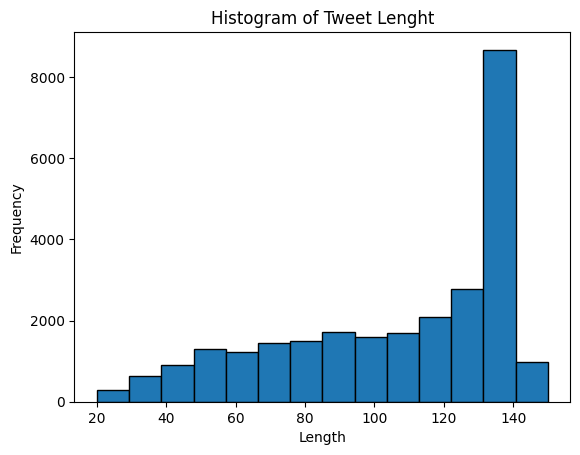

In [16]:
# length of docs in corpus
tweetlength = []
for tweet in df['tweet_text']:
    tweetlength.append(len(tweet))

plt.hist(tweetlength, bins=14, edgecolor='black')

plt.title('Histogram of Tweet Lenght')
plt.xlabel('Length')
plt.ylabel('Frequency')

## Loading Functions

In [17]:
def apply_stemming(in_text):
    stemmer=PorterStemmer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([stemmer.stem(w) for w in word_list])
    return output

In [18]:
def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

In [19]:
def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(in_text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    return filtered_sentence

In [20]:
def clean_doc(doc):
    #split document into individual words
    doc = ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)

    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    return tokens

In [39]:
sia = SentimentIntensityAnalyzer()
def analyze_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        return 'positive'
    elif sentiment_score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

## Sentiment Analysis

In [40]:
df['sentiment'] = df['tweet_text'].apply(analyze_sentiment)

In [41]:
df.head()

,id,candidate_id,tweet_id,polarity,subjectivity,lang,tweet_text,created_at,inserted_at,updated_at,sentiment
3,57832,1,770748171282620416,-0.40625,0.84375,en,@WSJ can we just report the results after Elec...,2016-08-30 22:20:58,2016-08-30 22:20:58,2016-08-30 22:20:58,negative
6,58082,2,770748351922839553,0.00000,0.00000,en,@politico @realDonaldTrump Trumpsters are all ...,2016-08-30 22:21:41,2016-08-30 22:21:41,2016-08-30 22:21:41,negative
7,58132,1,770748385699635201,0.00000,1.00000,en,"@DNCWomen @HillaryClinton ""And I see your VOTE...",2016-08-30 22:21:49,2016-08-30 22:21:49,2016-08-30 22:21:49,positive
12,58382,1,770748562137190400,0.00000,0.00000,en,@Al_Baldasaro \nI guess calling for the murder...,2016-08-30 22:22:31,2016-08-30 22:22:31,2016-08-30 22:22:31,negative
13,58482,2,770748625949425664,0.00000,0.00000,en,@PolitiSass @realDonaldTrump @Maggyw519 @About...,2016-08-30 22:22:46,2016-08-30 22:22:47,2016-08-30 22:22:47,positive


In [43]:
df['sentiment'].value_counts()

,count
sentiment,
negative,10255
positive,9660
neutral,6906


## TFIDF Scores

In [21]:
processed_text=[]
for i in list(df['tweet_text']):
  text=clean_doc(i)
  processed_text.append(text)

processed_text

[['report',
  'result',
  'election',
  'polls',
  'anything',
  'election',
  'hillaryclinton',
  'corrupt'],
 ['politico', 'realdonaldtrump', 'trumpsters'],
 ['dncwomen',
  'hillaryclinton',
  'votes',
  'hillary',
  'money',
  'power',
  'hillary'],
 ['albaldasaro', 'guess', 'calling', 'murder', 'hillaryclinton', 'upside'],
 ['politisass',
  'realdonaldtrump',
  'aboutcomics',
  'democrat',
  'never',
  'refused'],
 ['youcancallmefee',
  'clinton',
  'trump',
  'hillaryclinton',
  'realdonaldtrump',
  'sorry',
  'sorry'],
 ['politico',
  'realdonaldtrump',
  'hillaryclinton',
  'trump',
  'tweet',
  'something',
  'stupid',
  'anway'],
 ['davewhorton', 'realdonaldtrump', 'trump', 'asshole', 'taste'],
 ['hillaryclinton'],
 ['whoisneil', 'realdonaldtrump', 'wrong'],
 ['americooligan', 'hillaryclinton', 'whaaaaat'],
 ['onemikedinsmore', 'rustyrryan', 'realdonaldtrump', 'exactly'],
 ['colmorrisdavis',
  'realdonaldtrump',
  'grand',
  'marshall',
  'israeli',
  'parade',
  'israel',
  '

In [22]:
final_processed_text=[]

for i in processed_text:
  temp_DSI=i[0]
  for k in range(1,len(i)):
    temp_DSI=temp_DSI+' '+i[k]
  final_processed_text.append(temp_DSI)
final_processed_text


['report result election polls anything election hillaryclinton corrupt',
 'politico realdonaldtrump trumpsters',
 'dncwomen hillaryclinton votes hillary money power hillary',
 'albaldasaro guess calling murder hillaryclinton upside',
 'politisass realdonaldtrump aboutcomics democrat never refused',
 'youcancallmefee clinton trump hillaryclinton realdonaldtrump sorry sorry',
 'politico realdonaldtrump hillaryclinton trump tweet something stupid anway',
 'davewhorton realdonaldtrump trump asshole taste',
 'hillaryclinton',
 'whoisneil realdonaldtrump wrong',
 'americooligan hillaryclinton whaaaaat',
 'onemikedinsmore rustyrryan realdonaldtrump exactly',
 'colmorrisdavis realdonaldtrump grand marshall israeli parade israel right',
 'hillaryclinton really thinking ability',
 'realdonaldtrump prayers important speech tomorrow',
 'thehill realdonaldtrump breed',
 'ryangrim realdonaldtrump itsmarlamaples allowing credibility horrible piece',
 'jxbrowno lushcosmetics swpolice realdonaldtrump'

In [24]:
#vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, norm=None)
#transformed_documents = vectorizer.fit_transform(list(df['tweet_text']))
#transformed_documents_as_array = transformed_documents.toarray()

In [23]:
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(stop_words='english', ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names_out()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix, words

In [24]:
WCSS_list=[26049.929698781725, 26002.059938947834, 25940.982612628995, 25878.87064672413, 25820.687272242787, 25412.6913387863, 25404.5718687714, 25318.900431561124, 25301.861287426953, 25330.100968261806, 25269.876344694152, 25226.262946085517, 25216.08594639989, 25195.91892855796, 25192.30320208054, 25128.84584135388, 25127.562967489168, 25073.732126300198, 25040.009554019223, 25047.006887724358, 25802.190719867234, 25765.49002738997, 25706.936118760445, 25700.36451510584, 25614.5063748282, 25612.2133873828, 25557.777951755834, 25530.962544861697, 25487.641021938034, 25442.8941530015, 25026.820419503867, 24979.69598290606, 24968.69268127583, 24967.61626725341, 24902.195916143777, 24879.023011027664, 24891.699402513095, 24858.739028941283, 24865.50026911787, 24782.62607202969, 24769.74324216693, 24762.222862405295, 24739.617418002446, 24696.199960422044, 24707.537187090147, 24683.486891095825, 24659.818440900355, 24631.751315910806, 24648.36555966807, 24666.19007691521, 24565.8399313766, 24533.600363292353, 19443.735707256732, 24539.82501695809, 24512.896527306624, 22799.15132611277, 21642.34019762602, 20490.914385180684, 19902.816274342946, 19195.171570523384]
cluster_number=[5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 1000, 57, 58, 200, 400, 600, 800, 1100]

def k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k=10):

    #this is a function to generate the k-means output using the tfidf matrix.  Inputs
    #to the function include: titles of text, processed text, and desired k value.
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()
    wcss = km.inertia_

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    print("Top terms per cluster:")
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]

    terms_dict=[]


    #save the terms for each cluster and document to dictionaries.  To be used later
    #for plotting output.

    #dictionary to store terms and titles
    cluster_terms={}
    cluster_title={}


    for i in range(k):
        print("Cluster %d:" % i),
        temp_terms=[]
        temp_titles=[]
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
            terms_dict.append(terms[ind])
            temp_terms.append(terms[ind])
        cluster_terms[i]=temp_terms

        print("Cluster %d titles:" % i, end='')
        temp=frame[frame['Cluster']==i]
        for title in temp['Doc Name']:
            print(' %s,' % title, end='')
            temp_titles.append(title)
        cluster_title[i]=temp_titles

    WCSS_list.append(wcss)
    cluster_number.append(k)
    print(f'\nWithin-Cluster Sum of Squares (WCSS){wcss}')
    return clusters

In [ ]:
tfidf_matrix, terms = tfidf(final_processed_text, list(df['id']))
for clusternumber in [600,800]:
  clusters = k_means_tfidf(tfidf_matrix,terms,list(df['id']),final_processed_text, k=clusternumber)
  print(WCSS_list)
  print(cluster_number)

In [47]:
tfidf_matrix, terms = tfidf(final_processed_text, list(df['id']))

clusters = k_means_tfidf(tfidf_matrix,terms,list(df['id']),final_processed_text, k=600)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Streaming output truncated to the last 5000 lines.
 unfit
 wrong
 trump
 disgust
Cluster 145 titles: 57028966, 57029037, 59318, 67404, 57030517, 74459, 57031262, 89166, 57031793, 57044120, 57043191, 57033420, 104822, 115154, 115955, 117512, 122132, 122492, 127584, 57053045, 57053563, 57054028, 57103768, 57054248, 57099018, 57099085, 57055165, 57055191, 57055263, 142148, 57057162, 57057640,Cluster 146:
 keeping
 realdonaldtrump
 ditto
 great
 beauty
 thing
 working
 informed
 priority
 forefront
Cluster 146 titles: 57028860, 62913, 57030628, 57030781, 57029925, 76027, 89692, 101606, 57032275, 124536, 57054585, 57103864,Cluster 147:
 seriously
 realdonaldtrump
 hillaryclinton
 limbaugh
 sectl
 medium
 wonder
 fucking
 embarrassment
 leighbryan
Cluster 147 titles: 57029039, 61212, 57029592, 72641, 73478, 74093, 57030342, 78501, 80453, 57031335, 57031289, 57031466, 57031517, 57032031, 57032010, 97784, 101405, 100170, 107175, 107663, 108111, 57032623, 109874, 57032577, 57032859, 110326, 112

In [62]:
df['Cluster'] = clusters

In [67]:
selected_clusters = df['Cluster'].sample(n=20, random_state=89).unique()

In [68]:
subset_df = df[df['Cluster'].isin(selected_clusters)]

## Inertia for clusters

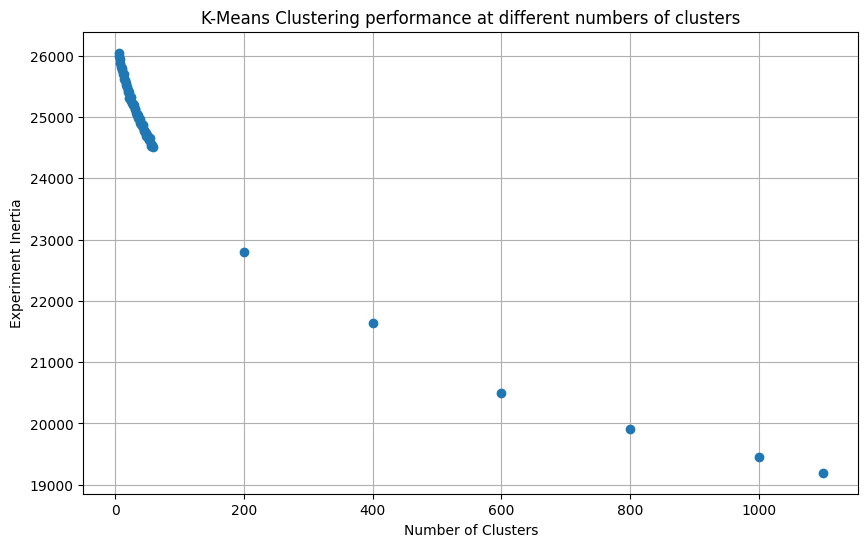

In [23]:
# finding the elbow point
ex3df = pd.DataFrame({'Cluster Inertia':WCSS_list,
                     'Number of Clusters':cluster_number})


plt.figure(figsize=(10, 6))
plt.plot(ex3df['Number of Clusters'], ex3df['Cluster Inertia'], label='Cluster Inertia', marker='o', linestyle='None')

plt.xlabel('Number of Clusters')
plt.ylabel('Experiment Inertia')
plt.title('K-Means Clustering performance at different numbers of clusters')
plt.grid(True);

## Cluster Sentiment

In [69]:
cluster_sentiment = subset_df.groupby('Cluster')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

<Axes: xlabel='Cluster'>

Text(0.5, 1.0, 'Sentiment Distribution by 20 Chosen Cluster')

Text(0.5, 0, 'Cluster')

Text(0, 0.5, 'Proportion')

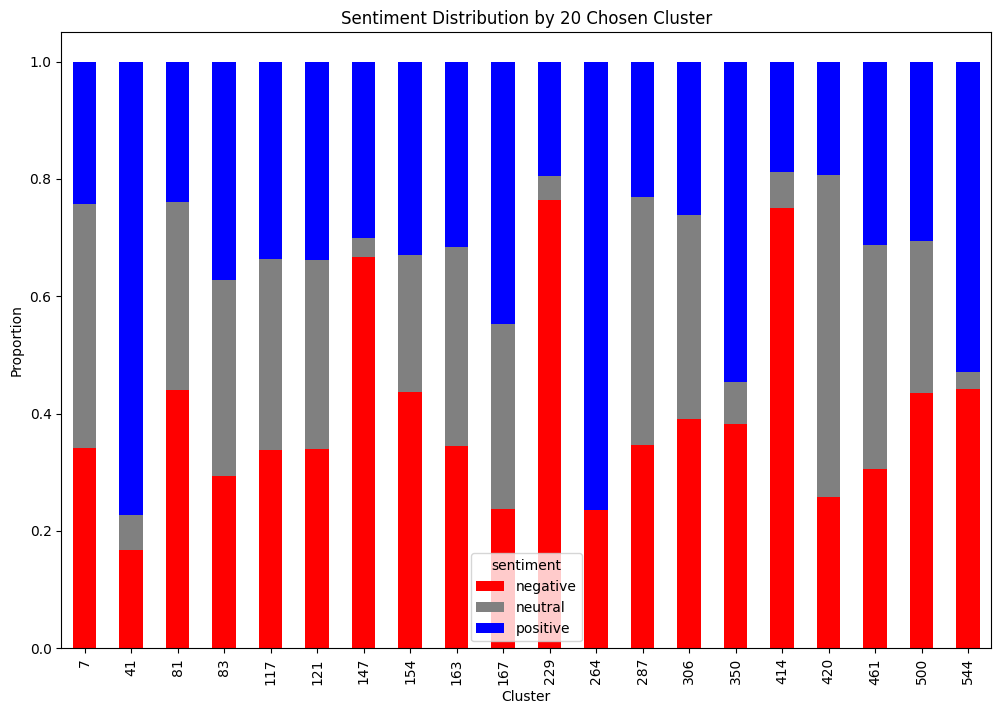

In [74]:
# Visualize sentiment distribution by cluster
custom_palette = {'positive': 'blue', 'neutral': 'gray', 'negative': 'red'}
cluster_sentiment.plot(kind='bar', stacked=True, figsize=(12, 8), color=[custom_palette[col] for col in cluster_sentiment.columns])
plt.title('Sentiment Distribution by 20 Chosen Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')

## Which Candidates are more present in each cluster

In [79]:
cluster_candidate = subset_df.groupby('Cluster')['candidate_id'].value_counts(normalize=True).unstack().fillna(0)

<Axes: xlabel='Cluster'>

Text(0.5, 1.0, 'Candidate Distribution by 20 Chosen Cluster')

Text(0.5, 0, 'Cluster')

Text(0, 0.5, 'Proportion')

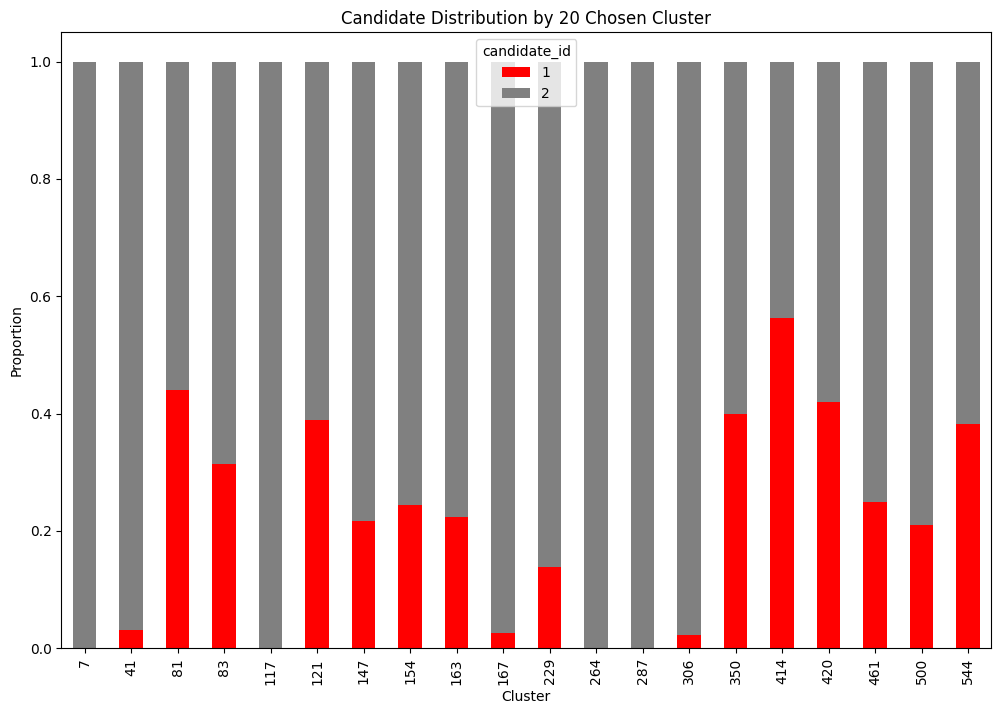

In [80]:
# Visualize candidate distribution by cluster
custom_palette = {'positive': 'blue', 'neutral': 'gray', 'negative': 'red'}
cluster_candidate.plot(kind='bar', stacked=True, figsize=(12, 8), color=[custom_palette[col] for col in cluster_sentiment.columns])
plt.title('Candidate Distribution by 20 Chosen Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')

## PCA Dimensionality Reduciton

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'PCA of TF-IDF Matrix')

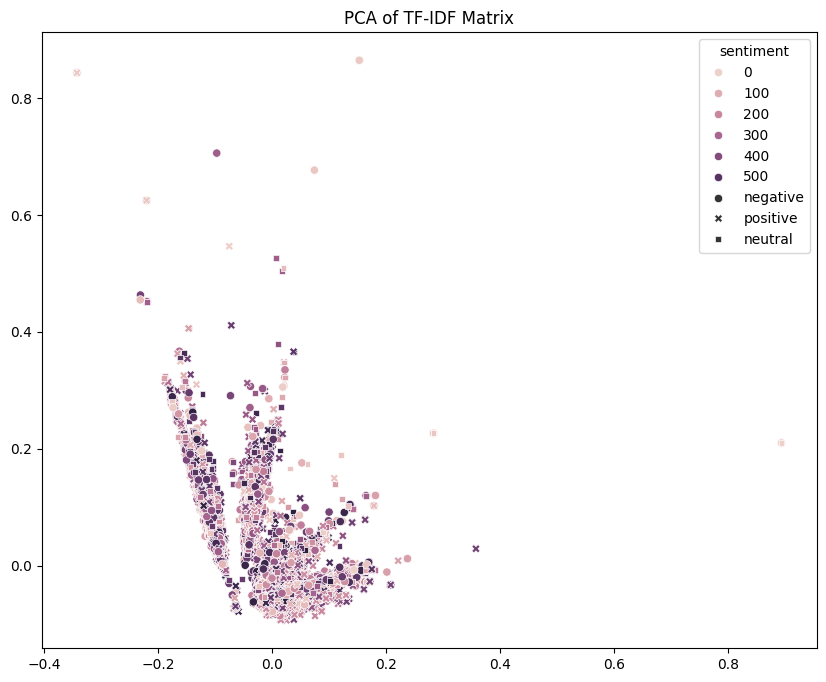

In [61]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.values)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, style=df['sentiment'])
plt.title('PCA of TF-IDF Matrix')

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'PCA of TF-IDF Matrix')

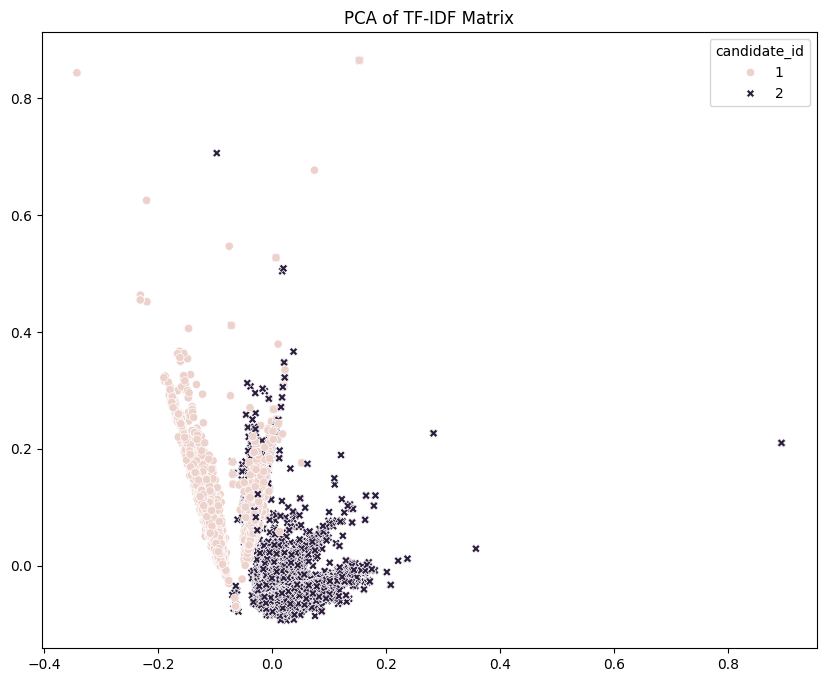

In [51]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.values)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['candidate_id'], style=df['candidate_id'])
plt.title('PCA of TF-IDF Matrix')

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'PCA of TF-IDF Matrix')

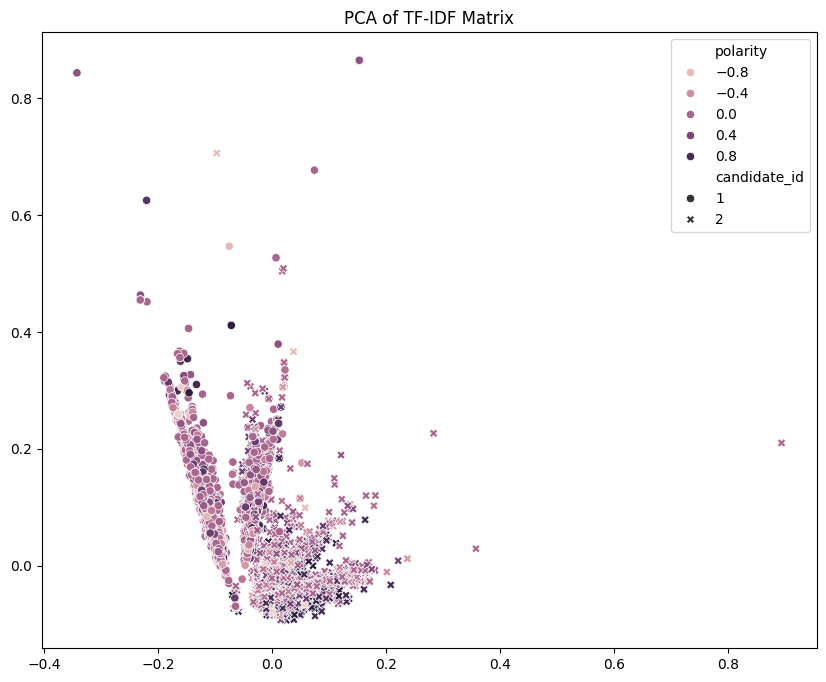

In [82]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.values)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['polarity'], style=df['candidate_id'], color=[custom_palette[col] for col in cluster_sentiment.columns])
plt.title('PCA of TF-IDF Matrix')

In [1]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.values)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=df['polarity'], style=df['candidate_id'], colormap='warmcool')
plt.title('PCA of TF-IDF Matrix')

NameError: name 'PCA' is not defined